In [1]:
import pickle
import sys
from pathlib import Path

import torch
import tqdm

In [2]:
LATENT_FILE = "latents.pkl"
DATA_FILE = "test.pkl"
MATRIX_FILE = "confusion_matrix.pkl"

In [3]:
from torch import nn, Tensor
from typing import Dict, Iterable, Callable


class FeatureExtractor(nn.Module):
    def __init__(self, model: nn.Module, layers: Iterable[str]):
        super().__init__()
        self.model = model
        self.layers = layers
        self._features = {layer: torch.empty(0) for layer in layers}

        for layer_id in layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            layer.register_forward_hook(self.save_outputs_hook(layer_id))

    def save_outputs_hook(self, layer_id: str) -> Callable:
        def fn(_, __, output):
            self._features[layer_id] = output

        return fn

    def forward(self, *x: Tensor) -> Dict[str, Tensor]:
        _ = self.model(*x)
        return self._features


@torch.no_grad()
def evaluate(model, data_loader, device):
    model.eval()
    model.to(device)

    # 用于存储预测正确的样本个数
    sum_num = torch.zeros(1).to(device)
    latents = []
    preds = []
    labels = []

    # 在进程0中打印验证进度
    data_loader = tqdm.tqdm(data_loader, file=sys.stdout)

    for step, data in enumerate(data_loader):
        features = model(
            data["pixel_values"].to(device),
            data["attention_mask"].to(device),
        )
        latents.extend(
            features["vit"]
            .last_hidden_state[:, 0, :]
            .detach().cpu().numpy()
        )
        pred = torch.max(features["classifier"], dim=1)[1]
        preds.extend(pred.detach().cpu().numpy())
        labels.extend(data["labels"])

    # 等待所有进程计算完毕
    return preds, labels, latents

In [4]:
from dataset.session_dataset import SessionDataSet
from model.mae import ViTMAEForImageClassification
from sklearn.metrics import confusion_matrix, classification_report


def run_eval(model_name_or_path, validation_dir: Path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ViTMAEForImageClassification.from_pretrained(model_name_or_path)
    pacth_size = model.vit.embeddings.patch_size
    pixels_per_patch = pacth_size[0] * pacth_size[1]
    num_patches = model.vit.embeddings.num_patches

    model_features = FeatureExtractor(model, layers=["vit", "classifier"])

    dataset = SessionDataSet(validation_dir, 1024, pixels_per_patch, num_patches, mode="finetune")
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=32,
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)
    preds, labels, latents = evaluate(model=model_features,
                                      data_loader=data_loader,
                                      device=device)
    conf_mtx = confusion_matrix(labels, preds)
    cls_report = classification_report(labels, preds)
    print(cls_report)

    with open(validation_dir.with_name(LATENT_FILE), "wb") as f:
        pickle.dump(latents, f)

    with open(validation_dir.with_name(MATRIX_FILE), "wb") as f:
        pickle.dump(conf_mtx, f)

In [5]:
from math import ceil
from sklearn import manifold, decomposition
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable

params = {'font.family': 'serif',
          'font.serif': 'Times New Roman',
          'font.style': 'normal',
          'font.weight': 'normal',  #or 'blod'
          'font.size': 10,  #or large,small
          }
rcParams.update(params)


def add_labels(ax, X_norm, y):
    df = pd.DataFrame(X_norm, columns=['x1', 'x2'])
    df['y'] = y
    center = df.groupby('y').mean()
    for index, row in center.iterrows():
        ax.text(
            row['x1'], row['x2'],
            index,
            horizontalalignment="center",
            verticalalignment="top",
            fontsize=20,
            color="black"
        )


embeddings = {
    "t-SNE": manifold.TSNE(
        n_components=2, perplexity=100, init="random", random_state=0,
        n_iter=500, learning_rate=200, n_jobs=-1
    ),
    # "mds": manifold.MDS(n_components=2, max_iter=500, n_init=4, n_jobs=16),
    # "iso_map": manifold.Isomap(n_neighbors=20, n_components=2, max_iter=500, n_jobs=-1),
    "PCA": decomposition.PCA(n_components=2),
}


def plot_ax(ax, X, y, name):
    X = MinMaxScaler().fit_transform(X)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, label=y, s=60, cmap="rainbow", edgecolors="black", alpha=0.3)
    # ax.legend(*scatter.legend_elements(), title="Classes", fontsize=16,
    #            bbox_to_anchor=(1.02, 0.5), loc="center left", borderaxespad=0)
    # ax.add_artist(legend1)

    add_labels(ax, X, y)
    ax.set_title(name, fontsize=20)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis("tight")

/root/PycharmProjects/FlowTransformer/vit-mae-finetune-data/ISCX-Tor-2016
Computing t-SNE...
Computing PCA...
/root/PycharmProjects/FlowTransformer/vit-mae-finetune-data/CIC-IDS-2018
Computing t-SNE...
Computing PCA...
/root/PycharmProjects/FlowTransformer/vit-mae-finetune-data/USTC-TFC-2016
Computing t-SNE...
Computing PCA...
/root/PycharmProjects/FlowTransformer/vit-mae-finetune-data/Cross-Platform (Android)
Computing t-SNE...
Computing PCA...


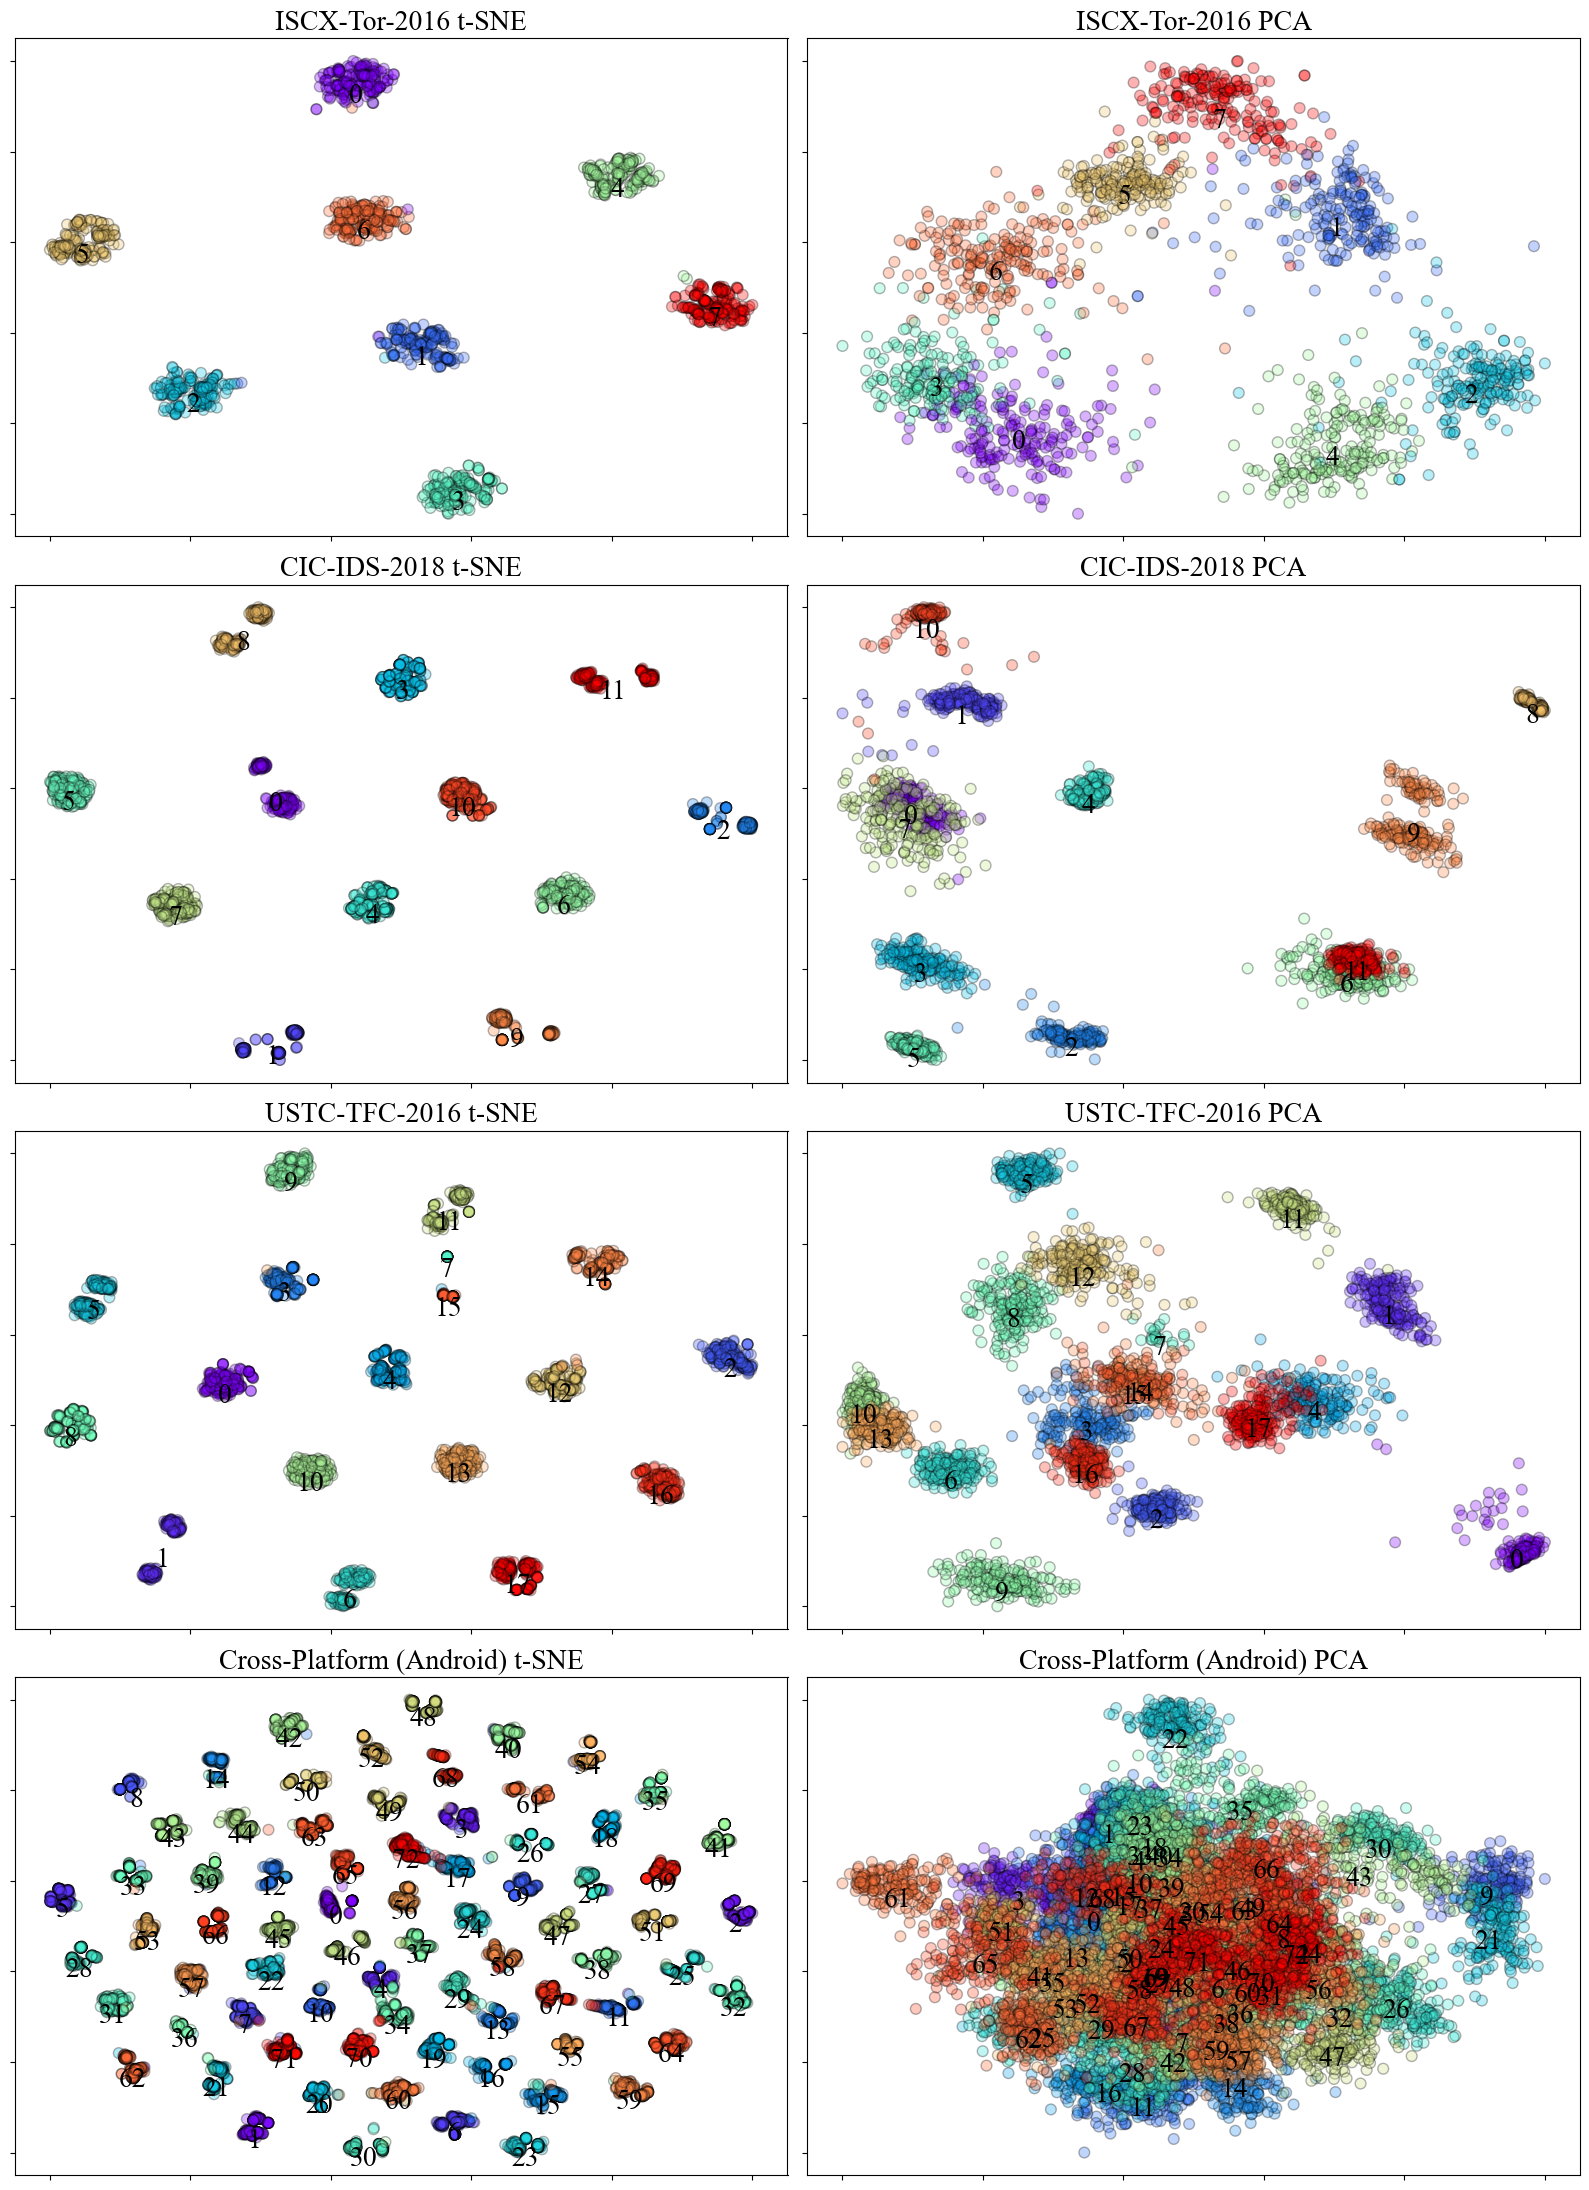

In [7]:
ckpt_root = Path("/root/PycharmProjects/FlowTransformer/vit-mae-finetune-data")
ckpt_dirs = list(ckpt_root.iterdir())

conf_mtxs = {}
projections = {}
Y = {}

# for ckpt_dir in ckpt_dirs:
# print(ckpt_dir)
# latents = pickle.load(open(ckpt_dir / LATENT_FILE, "rb"))
# data = pickle.load(open(ckpt_dir / DATA_FILE, "rb"))
# y = [d[2] for d in data]
#
# all = [(x, label) for x, label in zip(latents, y)]
# print(all[0])
# # with open(ckpt_dir.with_name("all.txt"), "wb") as f:
# #     for line in all:
# #         f.writelines(line)


for ckpt_dir in ckpt_dirs:
    print(ckpt_dir)
    # run_eval(ckpt_dir, ckpt_dir / DATA_FILE)

    conf_mtxs[ckpt_dir.name] = pickle.load(open(ckpt_dir / MATRIX_FILE, "rb"))
    latents = pickle.load(open(ckpt_dir / LATENT_FILE, "rb"))
    data = pickle.load(open(ckpt_dir / DATA_FILE, "rb"))
    y = [d[2] for d in data]

    for name, transformer in embeddings.items():
        print(f"Computing {name}...")
        sub_name = " ".join((ckpt_dir.name, name))
        projections[sub_name] = transformer.fit_transform(latents, y)
        Y[sub_name] = y

        # with open(ckpt_dir / f"{sub_name}.txt", "w") as f:
        #     for x, label in zip(projections[sub_name], Y[sub_name]):
        #         f.writelines(f"{x[0]} {x[1]} {label}\n")

fig, subplots = plt.subplots(len(ckpt_dirs), len(embeddings), figsize=(16, 22))
for ax, name in zip(subplots.flatten(), projections.keys()):
    plot_ax(ax, projections[name], Y[name], name)

fig.tight_layout()
plt.savefig("results.pdf")
plt.show()

In [55]:
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def heatmap(
        data,
        row_labels, col_labels,
        ylabel, xlabel,
        name=None,
        ax=None,
        cbar_kw=None,
        cbarlabel="",
        max_labels=None,
        **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    if row_labels is None:
        row_labels = np.arange(0, data.shape[0])
    if col_labels is None:
        col_labels = np.arange(0, data.shape[1])

    if max_labels is not None:
        data = data.copy()[:max_labels, :max_labels]
        row_labels = row_labels[:max_labels]
        col_labels = col_labels[:max_labels]

    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad=0.1)

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax_cb.figure.colorbar(im, cax=ax_cb, **cbar_kw)
    # ax_cb.yaxis.tick_right()
    # ax_cb.yaxis.set_tick_params(labelright=True)
    cbar.set_label(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_xlabel(xlabel)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)
    ax.set_ylabel(ylabel)

    # Let the horizontal axes labeling appear on bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - .5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - .5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    if name is not None:
        ax.set_title(name)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

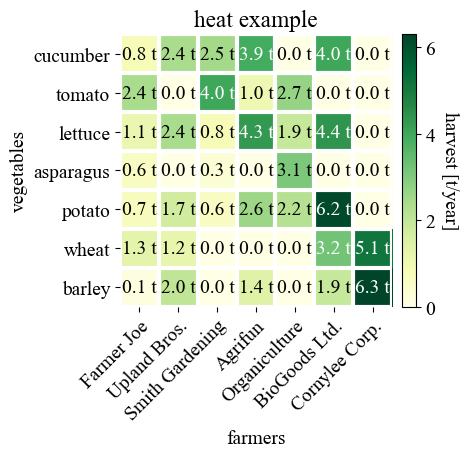

In [8]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

fig, ax = plt.subplots()

im, cbar = heatmap(harvest,
                   vegetables, farmers,
                   "vegetables", "farmers",
                   "heat example",
                   ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

AttributeError: 'NoneType' object has no attribute 'group'

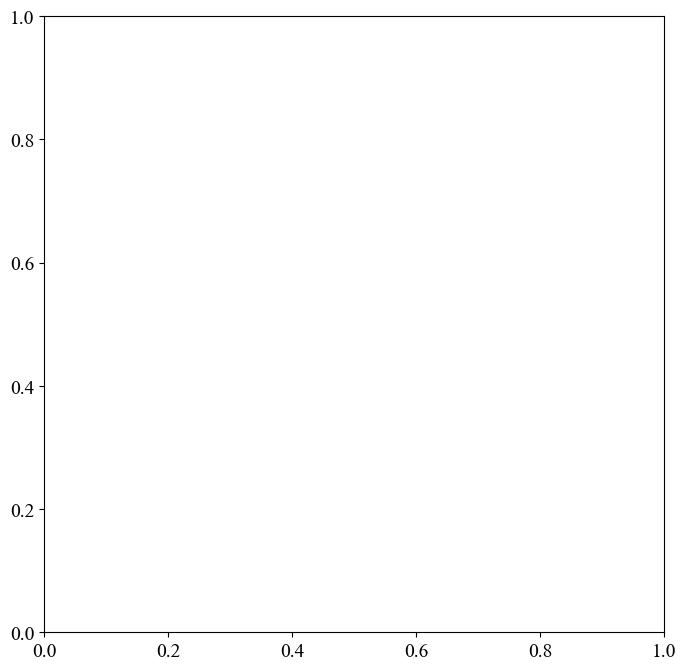

In [90]:
import re
import matplotlib.pyplot as plt


def tick_norm(x, pos):
    if x == 0:
        return ""
    if x == 1.0:
        return "1"
    return f"{x:.2f}"


def get_labels(data_path: Path):
    classes_map = {folder.name: folder.name.lower() for folder in data_path.iterdir()}
    # classes_map.sort(key=lambda x: x[1])
    classes = list(map(
        lambda x: re.match(r"(.*)\.pcap", x[0]).group(1),
        sorted(classes_map.items(), key=lambda x: x[1])
    ))
    print(classes)
    return classes


def plot_heatmap_ax(
        ax,
        matrix,
        data_path,
        name=None,
        max_labels=None,
        **annotate_kwargs
):
    matrix_norm = matrix / matrix.sum(axis=1)
    classes = get_labels(data_path)
    row_labels = classes
    col_labels = classes

    im, cbar = heatmap(
        matrix_norm,
        row_labels, col_labels,
        "True label", "Predicted label",
        name,
        ax=ax,
        cmap="YlGn",
        cbarlabel="Ratio",
        max_labels=max_labels,
    )
    texts = annotate_heatmap(im, valfmt=matplotlib.ticker.FuncFormatter(tick_norm), **annotate_kwargs)


fig, ax = plt.subplots(figsize=(8, 8))
data_path = Path("/mnt/data2/USTC-TFC2016/pcap")
plot_heatmap_ax(
    ax,
    conf_mtxs["USTC-TFC-2016"],
    data_path,
    None,
    fontsize=10
)
fig.tight_layout()
plt.savefig("USTC-TFC-2016.pdf", bbox_inches='tight')
plt.show()

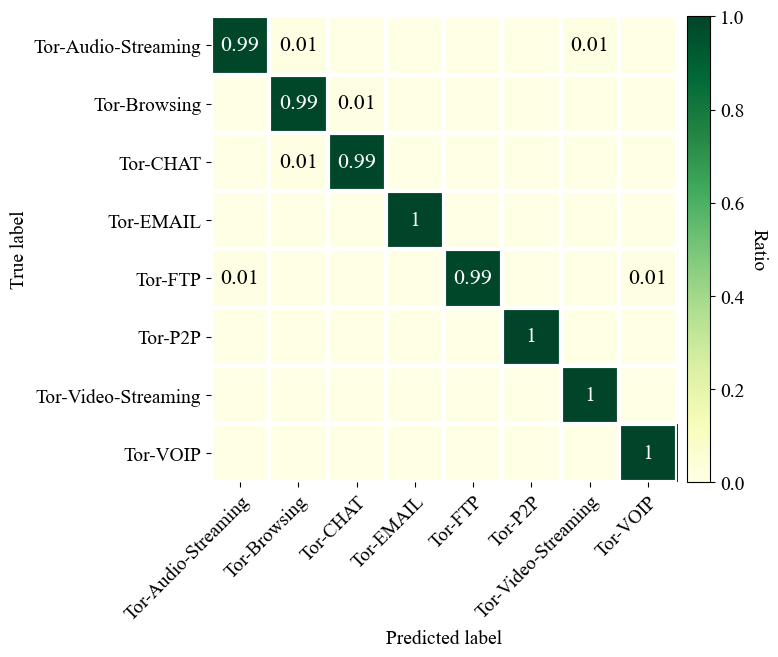

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

data_path = Path("/mnt/data2/ISCX-Tor-2016/Pcaps/tor")
plot_heatmap_ax(
    ax,
    conf_mtxs["ISCX-Tor-2016"],
    data_path,
    None,
    fontsize=16
)
fig.tight_layout()
plt.savefig("ISCX-Tor-2016.pdf", bbox_inches='tight')
plt.show()

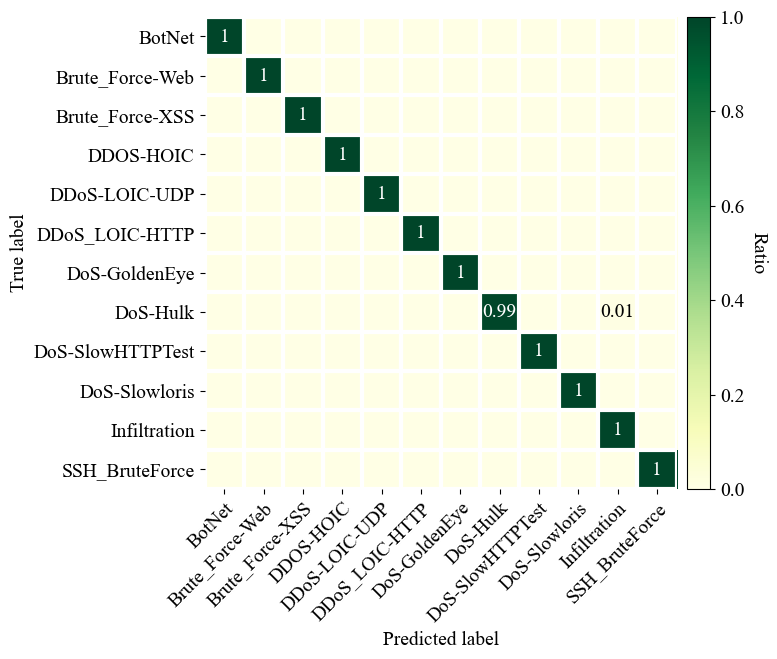

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

data_path = Path("/mnt/data/IDS2018black")

plot_heatmap_ax(
    ax,
    conf_mtxs["CIC-IDS-2018"],
    data_path,
    None,
    fontsize=14
)
fig.tight_layout()
plt.savefig("CIC-IDS-2018.pdf", bbox_inches='tight')
plt.show()

['bubei.tingshu', 'cn.cntvnews', 'com.achievo.vipshop', 'com.aikan', 'com.autonavi.minimap', 'com.baidu.BaiduMap', 'com.baidu.homework', 'com.baidu.wenku', 'com.book2345.reader', 'com.changba', 'com.coomix.app.bus', 'com.culiu.qqpurchase', 'com.dewmobile.kuaiya', 'com.dianping.v1', 'com.duomi.android', 'com.duowan.kiwi', 'com.duowan.mobile', 'com.ea.simcitymobile.tx', 'com.esbook.reader', 'com.fenbi.android.solar', 'com.handsgo.jiakao.android', 'com.happyelements.AndroidAnimal.qq', 'com.happyelements.AndroidClover.www', 'com.hunantv.imgo.activity', 'com.hzfb.racing8.tx', 'com.ifeng.fhdt', 'com.ifeng.news2', 'com.iflytek.inputmethod', 'com.immomo.momo', 'com.iooly.android.lockscreen', 'com.itings.myradio', 'com.jifen.qukan', 'com.jingdong.app.mall', 'com.kuaikan.comic', 'com.lanjingren.ivwen', 'com.lazyswipe', 'com.letv.android.client', 'com.meitu.meiyancamera', 'com.mfw.roadbook', 'com.mogujie', 'com.moji.mjweather', 'com.mt.mtxx.mtxx', 'com.netease.newsreader.activity', 'com.og.danjid

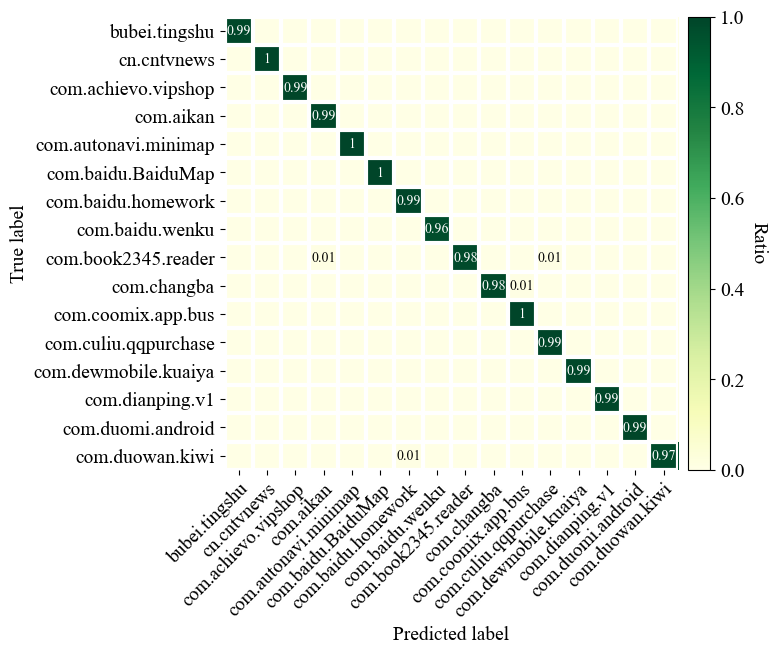

In [92]:
fig, ax = plt.subplots(figsize=(8, 8))

data_path = Path("/mnt/data2/CrossPlatform/pcap/china/android")
plot_heatmap_ax(
    ax,
    conf_mtxs["Cross-Platform (Android)"],
    data_path,
    None,
    max_labels=16,
    fontsize=10
)
fig.tight_layout()
plt.savefig("Cross-Platform (Android).pdf", bbox_inches='tight')
plt.show()

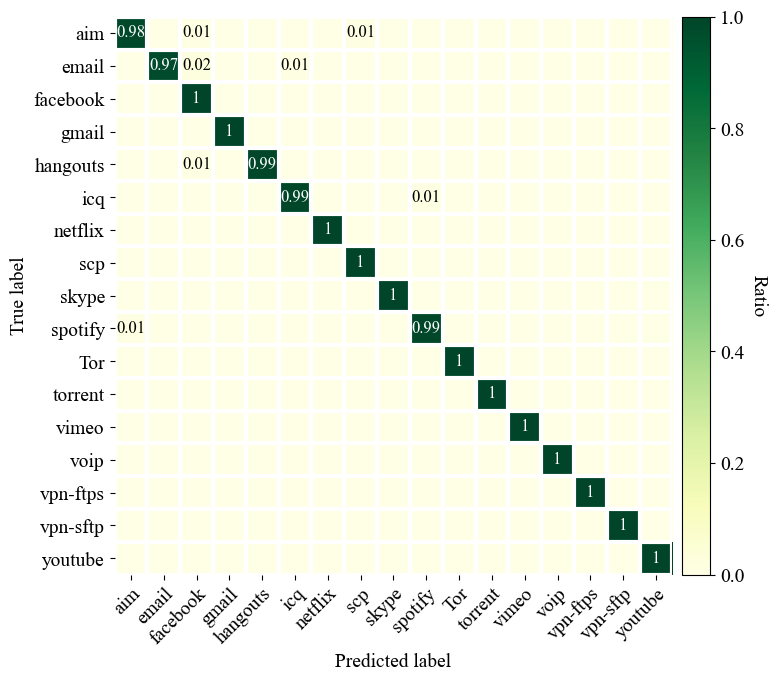

In [33]:
fig, ax = plt.subplots(figsize=(8, 8))
data_path = Path("/mnt/data2/ISCX-VPN-NonVPN-2016/ISCX-VPN-NonVPN-App")

conf_mtxs_2016App = np.zeros(shape=(17, 17))

for i in range(17):
    conf_mtxs_2016App[i, i] = 200

conf_mtxs_2016App[0, 0] -= 3
conf_mtxs_2016App[0, 2] = 2
conf_mtxs_2016App[0, 7] = 1

conf_mtxs_2016App[1, 1] -= 5
conf_mtxs_2016App[1, 2] = 4
conf_mtxs_2016App[1, 5] = 1

conf_mtxs_2016App[4, 4] -= 1
conf_mtxs_2016App[4, 2] = 1

conf_mtxs_2016App[5, 5] -= 2
conf_mtxs_2016App[5, 9] = 2

conf_mtxs_2016App[9, 9] -= 2
conf_mtxs_2016App[9, 0] = 2

plot_heatmap_ax(
    ax,
    conf_mtxs_2016App,
    data_path,
    None,
    fontsize=12
)
fig.tight_layout()
plt.savefig("ISCX-VPN-NonVPN-2016-App.pdf", bbox_inches='tight')
plt.show()

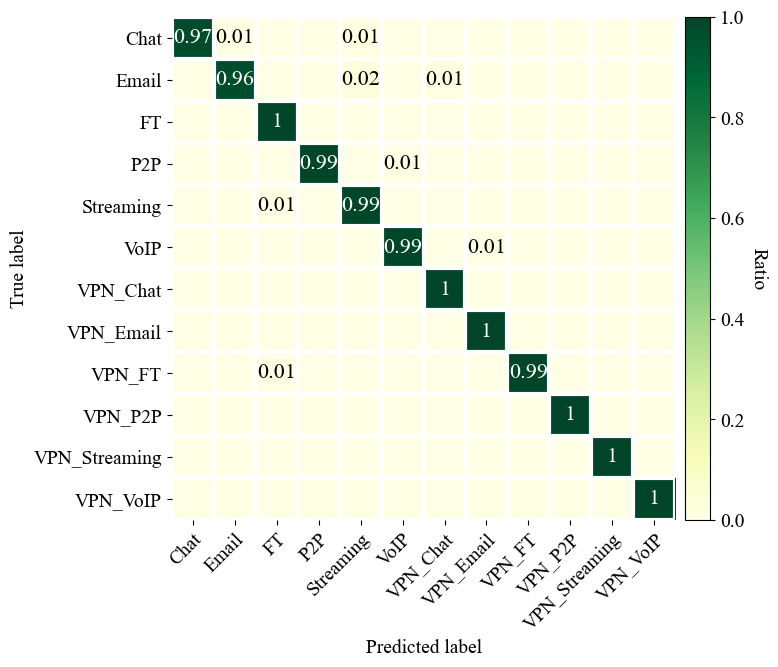

In [40]:
fig, ax = plt.subplots(figsize=(8, 8))
data_path = Path("/mnt/data2/ISCX-VPN-NonVPN-2016/Service/bak")

conf_mtxs_2016Service = np.zeros(shape=(12, 12))

for i in range(12):
    conf_mtxs_2016Service[i, i] = 200

conf_mtxs_2016Service[0, 0] -= 5
conf_mtxs_2016Service[0, 1] = 2
conf_mtxs_2016Service[0, 4] = 3

conf_mtxs_2016Service[1, 1] -= 7
conf_mtxs_2016Service[1, 4] = 4
conf_mtxs_2016Service[1, 6] = 3

conf_mtxs_2016Service[3, 3] -= 1
conf_mtxs_2016Service[3, 5] = 1

conf_mtxs_2016Service[4, 4] -= 1
conf_mtxs_2016Service[4, 2] = 1

conf_mtxs_2016Service[5, 5] -= 2
conf_mtxs_2016Service[5, 7] = 2

conf_mtxs_2016Service[8, 8] -= 1
conf_mtxs_2016Service[8, 2] = 1

plot_heatmap_ax(
    ax,
    conf_mtxs_2016Service,
    data_path,
    None,
    fontsize=16
)
fig.tight_layout()
plt.savefig("ISCX-VPN-NonVPN-2016-Service.pdf", bbox_inches='tight')
plt.show()